In [114]:
import numpy as np
import pandas as pd
import xgboost as xgb
import re
import sklearn
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier ,AdaBoostClassifier, 
                             GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold


In [122]:
train = pd.read_csv(r"C:\Users\admin\Downloads\titanic\train.csv")
test = pd.read_csv(r"C:\Users\admin\Downloads\titanic\test.csv")
PassengerId = test['PassengerId']

In [72]:
test.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
all_data = [train, test]

In [74]:
for data_set in all_data:
    data_set["Name_length"] = data_set["Name"].apply(len)
    data_set["Has_Cabin"] = data_set["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    data_set["FamilySize"] = data_set["SibSp"] + data_set["Parch"] + 1
    data_set["IsAlone"] = 0
    data_set.loc[data_set["FamilySize"] == 1, "IsAlone"] = 1
    data_set["Embarked"] = data_set["Embarked"].fillna("S")
    data_set["Fare"] = data_set["Fare"].fillna(train["Fare"].median())
# train["CategoricalFare"] = pd.qcut(train["Fare"], 4)


# Pandas Tips

1. pandas可以用apply(),类似于scala中的map()函数： 
                                               data["slice"].apply(lambda x: x+1);
2. pandas可以用map(),用于映射转换：
                                               data["slcie"].map({"a":"b"});
3. pandas中的qcut()可以用于快速进行类别标签：
                                               pd.qcut([1,2,3,4], 4);

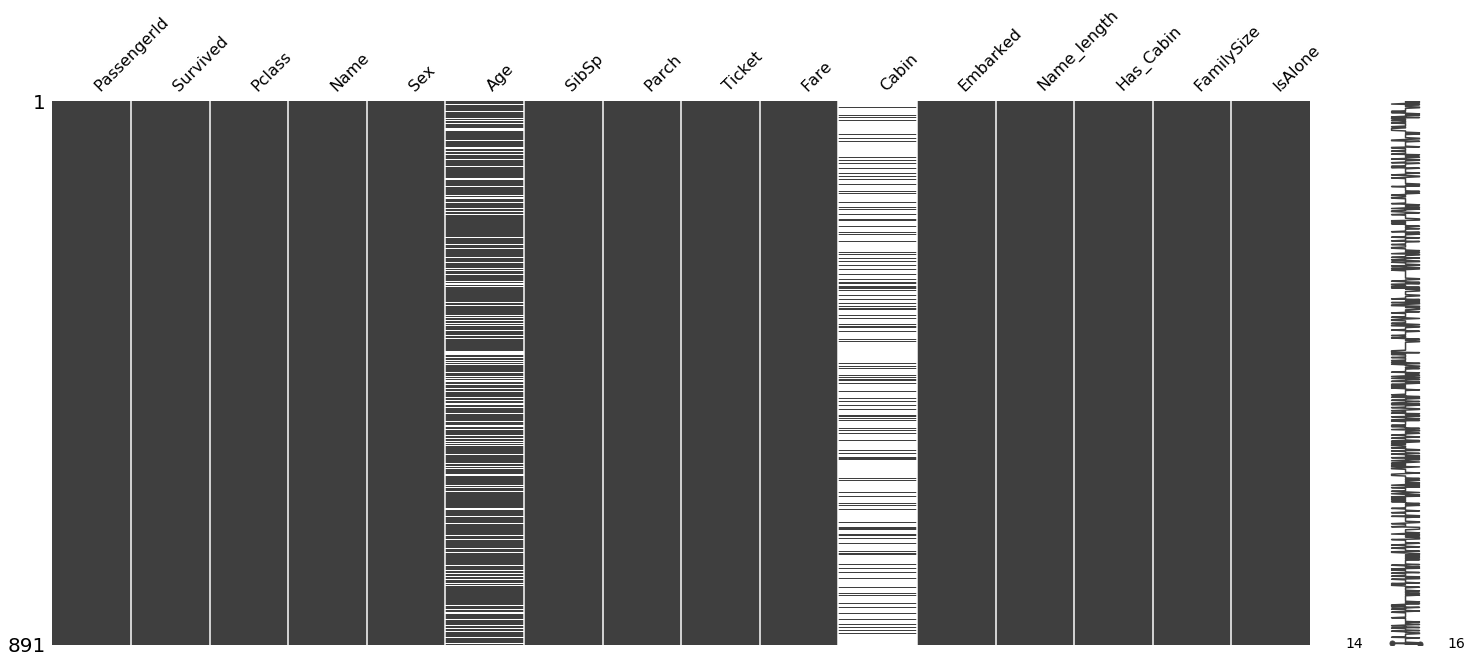

In [75]:
msno.matrix(train)

In [76]:
for data_set in all_data:
    age_avg = data_set["Age"].mean()
    age_std = data_set["Age"].std()
    age_null_count = data_set["Age"].isnull().sum()
    age_null_random = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    data_set["Age"][np.isnan(data_set["Age"])] = age_null_random
# data_set["Age_class"] = pd.cut(data_set["Age"], 5)

E:\swtx\annoconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [77]:
def get_title(name):
    sech = re.search(r"([A-Za-z]+)\.", name)
    if sech:
        return sech.group(1)
    return ""

for data_set in all_data:
    data_set["Title"] = data_set["Name"].apply(get_title)
    data_set["Title"] = data_set["Title"].replace(["Lady", "Countess", "Capy","Col","Don","Dr","Major","Rev",'Sir', 'Jonkheer', 'Dona'],"Rare")
    data_set['Title'] = data_set["Title"].replace("Ms", "Miss")
    data_set['Title'] = data_set["Title"].replace("Mme", "Mrs")
    data_set["Sex"] = data_set["Sex"].map({"female":0, "male":1}).astype(int)
    title_dcit = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data_set["Title"] = data_set["Title"].map(title_dcit)
    data_set["Title"] = data_set["Title"].fillna(0)
    data_set['Embarked'] = data_set['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    data_set.loc[ data_set['Fare'] <= 7.91, 'Fare'] = 0
    data_set.loc[(data_set['Fare'] > 7.91) & (data_set['Fare'] <= 14.454), 'Fare'] = 1
    data_set.loc[(data_set['Fare'] > 14.454) & (data_set['Fare'] <= 31), 'Fare'] = 2
    data_set.loc[ data_set['Fare'] > 31, 'Fare'] = 3 
    data_set.loc[ data_set['Age'] > 64, 'Age'] = 4 

In [78]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
# train = train.drop(["CategoricalFare", "Age_class"], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [79]:
train.describe()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,28.804343,0.381594,1.505051,0.361392,26.965208,0.228956,1.904602,0.602694,1.718294
std,0.486592,0.836071,0.477990,13.060329,0.806057,1.118148,0.635673,9.281607,0.420397,1.613459,0.489615,1.028958
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,12.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.000000,0.000000,0.500000,0.000000,20.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,2.000000,0.000000,25.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,37.000000,0.000000,2.000000,1.000000,30.000000,0.000000,2.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,64.000000,6.000000,3.000000,2.000000,82.000000,1.000000,11.000000,1.000000,5.000000


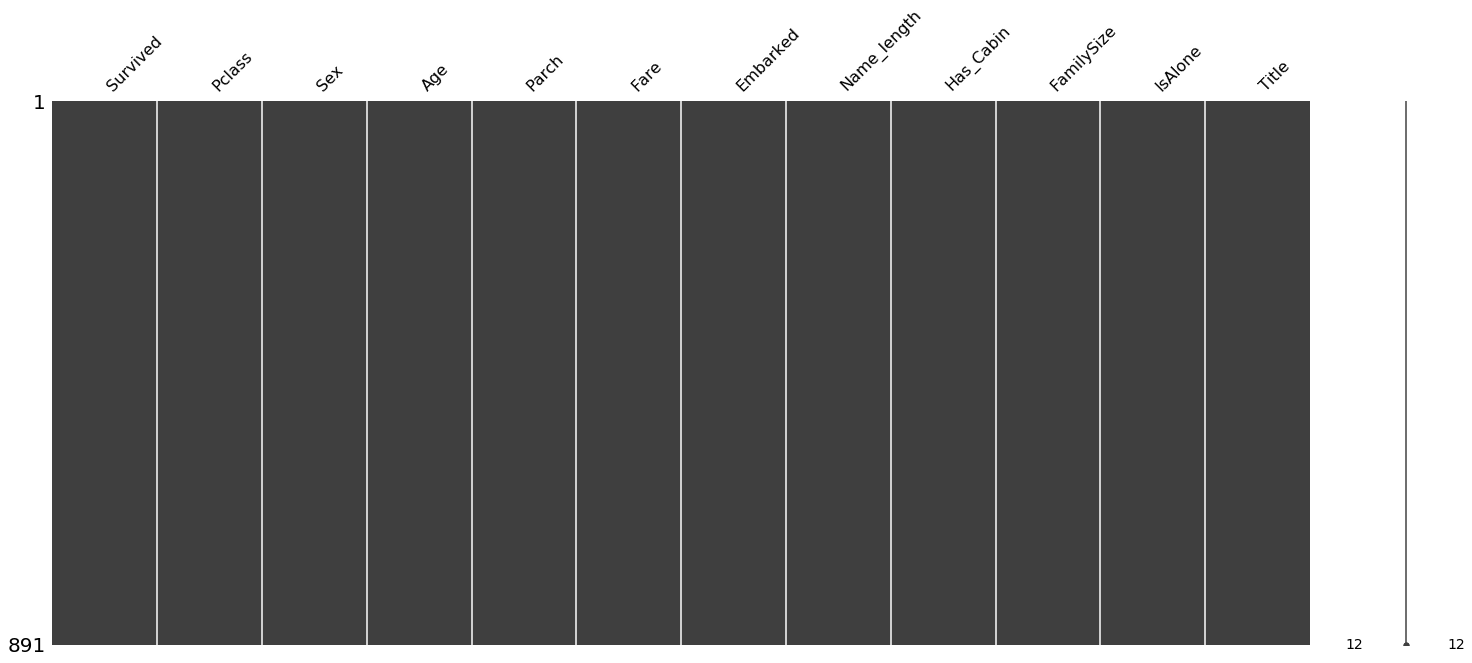

In [80]:
msno.matrix(train)

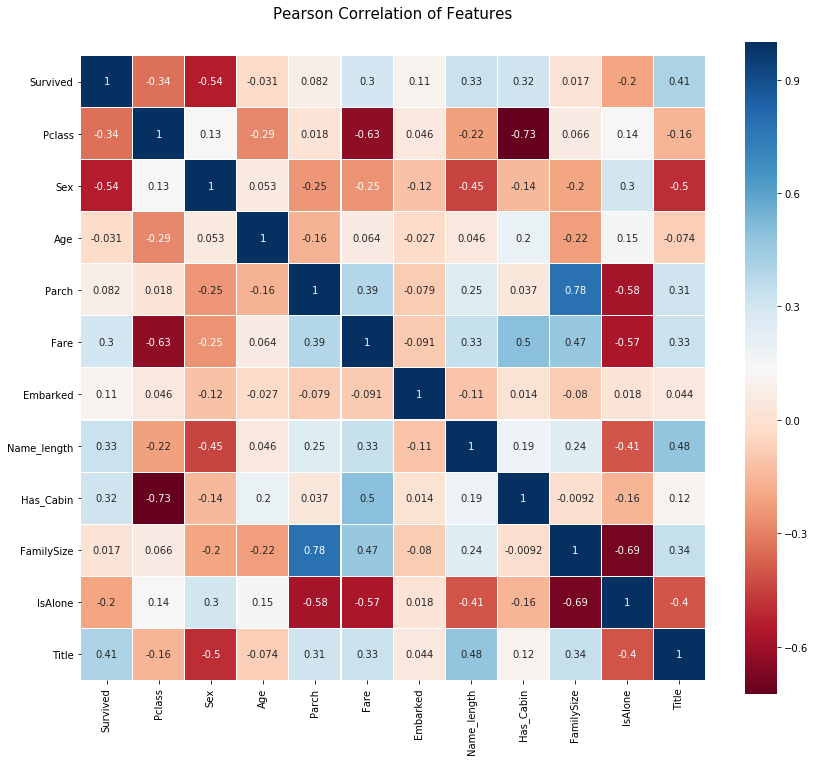

In [81]:
# 就是线条颜色
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [82]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params["random_state"]=seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)


def get_oof(clf, x_train, y_train, x_test):
    of_train = np.zeros((ntrain,))
    of_test = np.zeros((ntest,))
    of_test_kf = np.empty((NFOLDS, ntest))
    
    for i, (tr_index, te_index) in enumerate(kf):
        x_trian_tr = x_train[tr_index]
        y_train_tr = y_train[tr_index]
        x_train_te = x_train[te_index]
        
        clf.train(x_trian_tr, y_train_tr)
        
        of_train[te_index] = clf.predict(x_train_te)
        of_test_kf[i, :] = clf.predict(x_test)
        
    of_test[:] = of_test_kf.mean(axis=0)
    
    return of_train.reshape(-1, 1), of_test.reshape(-1, 1) 
        

In [83]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [84]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [85]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [87]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

E:\swtx\annoconda\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [104]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

[0.12305666 0.19536957 0.07587893 0.01877874 0.06841248 0.02191022
 0.09807611 0.062424   0.06421283 0.01269288 0.25918758]
[0.12196517 0.38887485 0.03207196 0.01616555 0.054098   0.02874621
 0.04755693 0.08440952 0.04454795 0.02208895 0.1594749 ]
[0.016 0.012 0.408 0.042 0.028 0.006 0.386 0.004 0.036 0.002 0.06 ]
[0.05413586 0.01775202 0.38336729 0.01577341 0.09238329 0.03590986
 0.28910322 0.0239734  0.03415207 0.01018967 0.04325992]


In [115]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })


In [120]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)



In [123]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
print(StackingSubmission)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         0
19           911         0
20           912         0
21           913         1
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         1
3